In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
import json
from collections import defaultdict, Counter

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, get_linear_schedule_with_warmup, EarlyStoppingCallback, pipeline


import pandas as pd
import os
import math
import requests
from typing import Optional, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, get_linear_schedule_with_warmup, EarlyStoppingCallback, pipeline
from transformers import AutoModel, PreTrainedTokenizerBase
from pyleetspeak.LeetSpeaker import LeetSpeaker


In [7]:
# set seed for reproducibility 
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)   
        
set_seed(42)

# Load Dataset

In [8]:
# load data
data_classes_two = np.load('../Data/classes_two.npy', allow_pickle=True)
data_classes = np.load('../Data/classes.npy', allow_pickle=True)

# fetch post IDs and their divisions
with open('../Data/post_id_divisions.json', 'r') as f:
    post_id_divisions = json.load(f)
# fetch dataset
with open('../Data/dataset.json', 'r') as f:
    data_ = json.load(f)


# Clean Test Data for Evalutation

In [9]:
# keep only test ids
test_ids = post_id_divisions['test']
# filter data_ to keep only test ids
data_test = {k: v for k, v in data_.items() if k in test_ids}  

## Functions

In [10]:
def compute_annotator_disagreement(dataset, verbose=False, return_top_n=0, plot=False):
    """
    Compute the number of unique labels assigned by annotators for each post,
    and optionally plot disagreement distribution.
    
    Args:
        dataset (dict): Loaded JSON dataset
        verbose (bool): Print summary stats
        return_top_n (int): If >0, return top N most disagreed examples
        plot (bool): If True, plot a histogram of disagreement levels

    Returns:
        disagreement_stats (list of tuples): (post_id, disagreement_count, label_counter)
        top_disagreements (optional): top N posts with highest disagreement
    """
    disagreement_stats = []

    for post_id, content in dataset.items():
        labels = [ann['label'] for ann in content.get('annotators', [])]
        label_counter = Counter(labels)
        disagreement_count = len(label_counter)
        disagreement_stats.append((post_id, disagreement_count, label_counter))

    if verbose:
        total = len(disagreement_stats)
        unanimous = sum(1 for _, c, _ in disagreement_stats if c == 1)
        mild_disagreement = sum(1 for _, c, _ in disagreement_stats if c == 2)
        full_disagreement = sum(1 for _, c, _ in disagreement_stats if c >= 3)

        print(f"Total examples: {total}")
        print(f"Unanimous (all annotators agree): {unanimous} ({unanimous/total:.2%})")
        print(f"Two-label disagreement: {mild_disagreement} ({mild_disagreement/total:.2%})")
        print(f"Three-label disagreement: {full_disagreement} ({full_disagreement/total:.2%})")

    if plot:
        disagreement_counts = [c for _, c, _ in disagreement_stats]
        count_dist = Counter(disagreement_counts)
        plt.bar(count_dist.keys(), count_dist.values(), color='gray')
        plt.xlabel("Number of unique labels (Disagreement level)")
        plt.ylabel("Number of posts")
        plt.title("Annotator Disagreement Distribution")
        plt.xticks([1, 2, 3])
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    if return_top_n > 0:
        top_disagreements = sorted(disagreement_stats, key=lambda x: -x[1])[:return_top_n]
        return disagreement_stats, top_disagreements

    return disagreement_stats


def resolve_disagreements_custom(dataset, disagreement_stats):
    resolved = []
    counter_unanimous = 0
    counter_hatespeech = 0
    counter_off_normal = 0
    counter_skipped = 0

    for post_id, disagreement, label_counts in disagreement_stats:
        if disagreement == 3:
            counter_skipped += 1
            continue  # skip level 3 disagreements

        text = " ".join(dataset[post_id]['post_tokens'])
        labels = list(label_counts.elements())
        label_set = set(label_counts.keys())

        # Case 1: unanimous
        if disagreement == 1:
            counter_unanimous += 1
            resolved_label = labels[0]

        # Case 2: offensive vs hatespeech → resolve as hatespeech
        elif disagreement == 2 and label_set == {"offensive", "hatespeech"}:
            counter_hatespeech += 1
            resolved_label = "hatespeech"

        # Case 3: normal vs offensive or normal vs hatespeech → majority
        else:
            counter_off_normal += 1
            resolved_label = Counter(labels).most_common(1)[0][0]

        resolved.append((text, resolved_label))

    # print(f"Unanimous: {counter_unanimous}, Offensive vs Hatespeech: {counter_hatespeech}, Normal vs Other: {counter_off_normal}, Skipped (3-label): {counter_skipped}")
    return resolved





## Clean data

In [11]:
disagreement_stats = compute_annotator_disagreement(data_test, verbose=True)
resolved_examples_custom = resolve_disagreements_custom(data_test, disagreement_stats)

test_data_clean = [
    (text, "toxic") if label == "hatespeech" else (text, "non-toxic")
    for text, label in resolved_examples_custom
    if label in {"hatespeech", "normal"}
]

Total examples: 1924
Unanimous (all annotators agree): 974 (50.62%)
Two-label disagreement: 950 (49.38%)
Three-label disagreement: 0 (0.00%)


In [12]:
len(test_data_clean)

1545

##### Use ```test_data_clean``` for evaluating model performance on non-perturbed test dataset

# Perturbed Test Data for Evaluation

## Rationale-based Perturbations

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
rationales = [
    (data_test[k]['rationales'])
    for k in data_test.keys()
]

posts = [
    (data_test[k]['post_tokens'])
    for k in data_test.keys()
]

In [15]:
MERGE_MODE = "union" # other possibilities: "majority" -> but may drop rare buzt valid toxic terms / else: intersection (POOR COVERAGE, TOO STRICT!!!!!!!!!!)

def merge_rationales(masks, n_tokens, mode="union"):
    """
    masks    : List[List[int]] (length 0–3, possibly wrong sizes)
    n_tokens : int  = len(post['post_tokens'])
    Returns   : merged mask (list[int]) or None if no valid annotator
    """
    # Keep only masks whose length matches the post
    arrs = [np.array(m) for m in masks if len(m) == n_tokens]

    if len(arrs) == 0:
        return None                      # no reliable annotator mask

    if mode == "union":
        merged = np.bitwise_or.reduce(arrs)
    elif mode == "majority":
        thr = (len(arrs) + 1) // 2       # majority among remaining annotators
        merged = (np.sum(arrs, axis=0) >= thr).astype(int)
    else:                                # "intersection"
        merged = np.bitwise_and.reduce(arrs)
    return merged.tolist()

def preprocess_record(post):
    text   = " ".join(post["post_tokens"])
    labels = [ann["label"] for ann in post["annotators"]]
    majority_label = Counter(labels).most_common(1)[0][0]

    n_tokens   = len(post["post_tokens"])
    merged_rat = None
    if majority_label in {"offensive", "hatespeech"} and post.get("rationales"):
        merged_rat = merge_rationales(post["rationales"], n_tokens, mode=MERGE_MODE)

    bin_label = "toxic" if majority_label in {"offensive", "hatespeech"} else "non-toxic"
    return text, bin_label, merged_rat


In [16]:
records = {pid: preprocess_record(post) for pid, post in data_test.items()}

In [17]:
toxic_data = [post for post, label in test_data_clean if label == "toxic"]
non_toxic_data = [post for post, label in test_data_clean if label == "non-toxic"] 

print(f"Number of toxic posts: {len(toxic_data)}")


Number of toxic posts: 763


In [18]:
# HARDKUMA

# -------------------------------------------------------------
# HardKuma distribution utilities (Bastings et al., 2020)
# -------------------------------------------------------------

class HardKumaSampler(nn.Module):
    """Samples a binary (0/1) mask via the HardKuma re‑parameterisation.

    Given shape (alpha) and rate (beta) > 0, the sampler draws a sample z in
    the open interval (0, 1) during the forward pass, then hard‑rounds it to
    {0,1} while using the soft value for gradient flow (straight‑through).
    """

    def __init__(self, eps: float = 1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, alpha: torch.Tensor, beta: torch.Tensor, hard: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
        """Return (z_hard, z_soft).

        z_soft is the continuous sample; z_hard is detached to be exactly 0/1
        but uses z_soft in the backward pass (straight‑through).
        """
        # Sample u ~ Uniform(0, 1)
        u = torch.rand_like(alpha)
        v = (1 - u.pow(1.0 / beta)).clamp(self.eps, 1 - self.eps)
        z_soft = (1 - v.pow(1.0 / alpha)).clamp(self.eps, 1 - self.eps)

        if hard:
            z_hard = (z_soft > 0.5).float()
            # Straight‑through gradient: replace hard with soft in backward
            z_hard = z_hard.detach() - z_soft.detach() + z_soft
        else:
            z_hard = z_soft
        return z_hard, z_soft

# -------------------------------------------------------------
# Rationale Generator + Predictor model
# -------------------------------------------------------------
class HardKumaRationaleModel(nn.Module):
    """Generator‑Predictor architecture for rationale extraction.

    * Generator: produces binary mask z over tokens via HardKuma.
    * Predictor: applies BERT to the masked input and predicts toxicity.
    """

    def __init__(self, bert_name: str = "bert-base-uncased", max_len: int = 128):
        super().__init__()
        self.max_len = max_len
        self.bert = AutoModel.from_pretrained(bert_name)
        hidden_size = self.bert.config.hidden_size

        # Generator head → 2 positives (alpha, beta) per token
        self.gen_head = nn.Linear(hidden_size, 2)
        self.hardkuma = HardKumaSampler()

        # Classifier head on [CLS]
        self.cls_head = nn.Linear(hidden_size, 1)

    # ------------------------------------------------------------------
    # Mask application helper
    # ------------------------------------------------------------------
    @staticmethod
    def apply_mask(embeddings: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """Element‑wise multiply embeddings by z (shape: batch × seq_len × 1)."""
        return embeddings * z.unsqueeze(-1)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        rationale_labels: Optional[torch.Tensor] = None,
        lambda_len: float = 1.0,
        lambda_cont: float = 1.0,
        lambda_sup: float = 1.0,
    ) -> dict:
        # BERT contextual embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden = outputs.last_hidden_state  # (B, L, H)

        # Generator: predict alpha, beta > 0 via softplus
        alpha_beta = F.softplus(self.gen_head(hidden)) + 1e-4  # (B, L, 2)
        alpha, beta = alpha_beta[..., 0], alpha_beta[..., 1]

        z, z_soft = self.hardkuma(alpha, beta)  # (B, L)
        masked_hidden = self.apply_mask(hidden, z)

        # Predictor on masked sequence (take [CLS])
        cls_repr = masked_hidden[:, 0, :]
        logits = self.cls_head(cls_repr).squeeze(-1)  # (B,)

        # ----------------------------------------------------------
        # Loss components
        # ----------------------------------------------------------
        out = {"logits": logits, "z_hard": z, "z_soft": z_soft}

        if rationale_labels is not None:
            # Binary cross‑entropy for token supervision
            sup_loss = F.binary_cross_entropy(z_soft, rationale_labels.float(), reduction="none")
            sup_loss = (sup_loss * attention_mask).sum() / attention_mask.sum()
            out["sup_loss"] = sup_loss * lambda_sup
        else:
            out["sup_loss"] = 0.0 * logits.sum()

        # Length regulariser: encourage sparse mask
        avg_len = z_soft.mean()
        len_loss = avg_len * lambda_len
        out["len_loss"] = len_loss

        # Continuity regulariser: encourage contiguous spans
        diff = torch.abs(z_soft[:, 1:] - z_soft[:, :-1]) * attention_mask[:, 1:]
        cont_loss = diff.mean() * lambda_cont
        out["cont_loss"] = cont_loss

        # Classification loss must be computed outside (BCEWithLogitsLoss)
        return out

# -------------------------------------------------------------
# Training step utility
# -------------------------------------------------------------
def training_step(batch, model, criterion, lambdas):
    # unpack & move to device
    input_ids, attn_mask, labels, rat_labels = (t.to(DEVICE) for t in batch)

    out = model(
        input_ids=input_ids,
        attention_mask=attn_mask,
        rationale_labels=rat_labels,
        lambda_len=lambdas["len"],
        lambda_cont=lambdas["cont"],
        lambda_sup=lambdas["sup"],
    )

    sup_loss_raw = out["sup_loss"]                     # (scalar per sample)
    has_mask     = (rat_labels.sum(dim=1) > 0).float()
    sup_loss     = (sup_loss_raw * has_mask).sum() / has_mask.sum().clamp(min=1)

    clf_loss   = criterion(out["logits"], labels)
    total_loss = clf_loss + sup_loss + out["len_loss"] + out["cont_loss"]
    out.update({"clf_loss": clf_loss, "total_loss": total_loss})

    # Cast labels to int **once** for metric calculation later
    labels_long = labels.long()
    return out, labels_long



# dataset wrapper

class HateXplainDataset(Dataset):
    """
    Each item from `data_binary` is a (text, label_str) tuple where
        label_str ∈ {"toxic", "non-toxic"}.
    Optionally supply `rat_masks` - a list (same length) where each element is
    either:
        * list[int] of 0/1 at **word** level  (toxic post with annotation)
        * None                                (toxic post w/out annot OR non-toxic)
    The class:
        • tokenises with HF tokenizer
        • aligns word-level rationale to WordPiece level
        • outputs (input_ids, attention_mask, label_float, rat_mask, sup_weight)
    """

    LABEL_MAP = {"non-toxic": 0.0, "toxic": 1.0}

    def __init__(self, pairs, ratm, tokenizer, max_len):
        self.pairs, self.ratm = pairs, ratm
        self.tok, self.max_len = tokenizer, max_len

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        text, lbl = self.pairs[idx]
        label = torch.tensor(self.LABEL_MAP[lbl])
        enc = self.tok(text, truncation=True, padding="max_length",
                       max_length=self.max_len, return_offsets_mapping=True,
                       return_tensors="pt")
        ids  = enc["input_ids"].squeeze(0)
        attn = enc["attention_mask"].squeeze(0)
        offs = enc["offset_mapping"].squeeze(0)

        # ----- build rationale mask -----
        if self.ratm[idx] is not None:            # toxic with annotation
            word_mask = torch.tensor(self.ratm[idx], dtype=torch.float)
            wp2word = (offs[:,0]==0).cumsum(0)-1
            wp2word[wp2word < 0] = -1
            wp2word[wp2word >= len(word_mask)] = -1
            sel   = wp2word >= 0
            rmask = torch.zeros_like(ids, dtype=torch.float)
            rmask[sel] = word_mask[wp2word[sel]]
        else:
            rmask = torch.zeros_like(ids, dtype=torch.float)

        return ids, attn, label, rmask


In [19]:
CKPT_DIR = "../Models/hardkuma_ckpt"

tokenizer = AutoTokenizer.from_pretrained(CKPT_DIR)

# 3.2  Read metadata, recreate the architecture skeleton
meta  = json.load(open(f"{CKPT_DIR}/training_meta.json"))
model = HardKumaRationaleModel(
            bert_name = meta["bert_model_name"],
            max_len   = meta["max_len"]
        )
model.load_state_dict(torch.load(f"{CKPT_DIR}/pytorch_model.bin",
                                 map_location=DEVICE))
model.to(DEVICE).eval()

HardKumaRationaleModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [20]:
def collate(batch):
    return tuple(torch.stack(items) for items in zip(*batch))

def find_rationales(texts, model, tokenizer, max_len=128, batch_size=16):
    """
    Args:
        texts      : List[str] toxic posts (e.g. from CSV)
        model      : trained HardKumaRationaleModel (already loaded and .eval())
        tokenizer  : tokenizer matching the model
        max_len    : max token length (same as used during training)
        batch_size : batch size for inference

    Returns:
        List[Dict] — for each text:
            {
              'tokens':            List[str] (WordPiece tokens),
              'rationale_mask':    List[int] (0/1, aligned with tokens),
              'rationale_tokens':  List[str] (non-special tokens where mask == 1)
            }
    """
     # -- dataset: wrap each string with a dummy "toxic" label
    dataset = HateXplainDataset(
                [(t, "toxic") for t in texts],   # pairs (text, label)
                ratm=[None] * len(texts),        # no human rationales
                tokenizer=tokenizer,
                max_len=max_len
             )
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=collate)

    results = []
    model.eval()
    with torch.no_grad():
        for ids, attn, _, _ in loader:           # 4-tuple per collate
            ids, attn = ids.to(DEVICE), attn.to(DEVICE)
            z_hard    = model(ids, attn)["z_hard"].cpu()   # (B, L)

            for wp_ids, wp_mask, z in zip(ids.cpu(),
                                          attn.cpu(),
                                          z_hard):
                tokens = tokenizer.convert_ids_to_tokens(wp_ids.tolist())
                rationale_tokens = [
                    tok for tok, m, zh in zip(tokens, wp_mask, z)
                    if m == 1 and zh == 1
                       and tok not in ("[CLS]", "[SEP]", "[PAD]")
                ]
                results.append(
                    dict(tokens=tokens,
                         rationale_mask=z.int().tolist(),
                         rationale_tokens=rationale_tokens)
                )
    return results




In [21]:
rationale_outputs = find_rationales(toxic_data, model=model, tokenizer=tokenizer, max_len=128 , batch_size=16)

# Inspect the first results
for i in range(10):
    print(f"\nPost {i+1}")
    print("Words:", rationale_outputs[i]["tokens"])
    print("Rationales:", rationale_outputs[i]["rationale_tokens"])


Post 1
Words: ['[CLS]', 'laura', 'lo', '##ome', '##r', 'raped', 'me', 'while', 'screaming', 'at', 'me', 'in', 'her', 'disgusting', 'ki', '##ke', 'language', 'and', 'said', 'we', 'must', 'ex', '##ter', '##minate', 'the', 'go', '##yi', '##m', 'laura', 'lo', '##ome', '##r', 'lo', '##ome', '##rga', '##te', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

## Homoglyph+Leetspeak Perturbations

In [22]:
len(test_data_clean), len(toxic_data), len(non_toxic_data)

(1545, 763, 782)

In [23]:
# Turn generated posts into the same “pair + mask” format

# 1. Toxic generated posts
gen_tox_pairs = [(text, "toxic") for text in toxic_data]
gen_tox_rats  = [out["rationale_mask"] for out in rationale_outputs]

# 2. Non-toxic generated posts (no rationales)
gen_nontox_pairs = [(text, "non-toxic") for text in non_toxic_data]
gen_nontox_rats  = [None] * len(gen_nontox_pairs)

test_pairs = gen_tox_pairs + gen_nontox_pairs
test_rats = gen_tox_rats + gen_nontox_rats  

In [24]:
def build_homoglyph_map():
    url = "https://www.unicode.org/Public/security/latest/confusables.txt" 
    response = requests.get(url) # Fetch the confusables data
    raw_text = response.text     # Get the text content

    homoglyph_map = defaultdict(list) 

    for line in raw_text.splitlines():
        if line.startswith('#') or not line.strip(): # Skip comments and empty lines
            continue
        try:
            src_hex, target_hex, *_ = line.split(';') # 
            src_char = chr(int(src_hex.strip(), 16))
            target_chars = ''.join([chr(int(h, 16)) for h in target_hex.strip().split()])

            # We only want visually similar substitutions that map to 1 character
            if len(src_char) == 1 and len(target_chars) == 1:
                ascii_base = target_chars.lower()
                if ascii_base.isascii() and ascii_base.isalnum():
                    homoglyph_map[ascii_base].append(src_char)
        except Exception as e:
            continue  # skip malformed lines

    # Convert defaultdict to normal dict and deduplicate entries
    homoglyph_map = {k: list(set(v)) for k, v in homoglyph_map.items()}

    return homoglyph_map

# 0.2  simple leet converter (stub)
class SimpleLeeter:
    _map = str.maketrans("aeios", "43105")  # toy map, replace with yours
    def text2leet(self, word): return word.translate(self._map)

# 1.1  convert rationale_tokens list ➜ target_words set (lower-case)
def toks_to_wordset(tok_list):
    return set(t.lower() for t in tok_list)

# 1.2  make HateXplain-style record
def make_record(text, label_str, rat_mask=None):
    return (text, label_str), rat_mask

def perturb_token(token, homoglyph_map, leeter, mode):
    # strip ## for sub-words, re-attach later
    prefix = "##" if token.startswith("##") else ""
    core   = token[2:] if prefix else token

    if mode in ("homoglyph", "both"):
        core = ''.join(
            random.choice(homoglyph_map[c]) if c in homoglyph_map and random.random()<0.5 else c
            for c in core
        )
    if mode in ("leet", "both"):
        core = leeter.text2leet(core)
    return prefix + core

def random_homoglyph_substitution(text, homoglyph_map, prob=0.4):
    new_text = ""
    for char in text:
        if char.isalpha() and char.lower() in homoglyph_map and random.random() < prob:
            replacement = random.choice(homoglyph_map[char.lower()])
            new_text += replacement
        else:
            new_text += char
    return new_text

def smart_homoglyph_substitution(text, homoglyph_map, target_words, prob=0.5):
    tokens = text.split()
    new_tokens = []

    for token in tokens:
        if any(word in token.lower() for word in target_words) and random.random() < prob:
            new_token = ''.join(
                random.choice(homoglyph_map[c.lower()]) if c.lower() in homoglyph_map and random.random() < 0.5 else c
                for c in token
            )
            new_tokens.append(new_token)
        else:
            new_tokens.append(token)

    return ' '.join(new_tokens)

def leet_some_words(text, leeter, word_prob=0.6):
    """
    Randomly leet some words in the text based on a probability.
    """
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < word_prob:
            new_words.append(leeter.text2leet(word))
        else:
            new_words.append(word)
    return ' '.join(new_words)

def augment_text(text, leeter, homoglyph_map, target_words=None):
    mode = random.choice(["leet", "homoglyph", "both"])

    if mode == "leet":
        text = leet_some_words(text, leeter)
    elif mode == "homoglyph":
        text = smart_homoglyph_substitution(text, homoglyph_map, target_words or [])
    elif mode == "both":
        text = leet_some_words(text, leeter)
        text = smart_homoglyph_substitution(text, homoglyph_map, target_words or [])
    # mode == "none": return as is
    return text

def augment_tokens(tokens, mask, homoglyph_map, leeter, p_apply=0.8):
    """
    tokens: list[str] WordPiece
    mask  : list[int] 0/1 aligned (None → treat as all zeros)
    """
    if mask is None or random.random() > p_apply:
        return tokenizer.convert_tokens_to_string(tokens)   # leave unchanged

    mode = random.choice(["homoglyph", "leet", "both"])
    new_tokens = [
        perturb_token(tok, homoglyph_map, leeter, mode) if m==1 else tok
        for tok, m in zip(tokens, mask)
    ]
    return tokenizer.convert_tokens_to_string(new_tokens)

def build_augmented_texts(pairs, rats, tokenizer, homoglyph_map, leeter):
    aug_texts, aug_labels = [], []
    for (txt, lab), mask in zip(pairs, rats):
        # tokenize original because rats is word-level for original splits
        if mask is not None and isinstance(mask[0], int):           # word-level?
            ids = tokenizer(txt, add_special_tokens=True)["input_ids"]
            tokens = tokenizer.convert_ids_to_tokens(ids)
            # For original data, we already aligned rat_mask to WordPiece earlier
            wp_mask = mask                                           
        else:   # for generated tox we already have WordPiece tokens
            tokens  = tokenizer.tokenize(txt)
            wp_mask = mask if mask is not None else [0]*len(tokens)

        augmented = augment_tokens(tokens, wp_mask,
                                   homoglyph_map, leeter)
        aug_texts.append(augmented); aug_labels.append(lab)
    return aug_texts, aug_labels

In [25]:
homoglyph_map = build_homoglyph_map()
leeter = SimpleLeeter()

# test aug : a list of (text, label) pairs
# test lab : a list of labels corresponding to the augmented texts

test_aug,  test_lab  = build_augmented_texts(test_pairs,  test_rats,
                                             tokenizer, homoglyph_map, leeter) 

aug_test_pairs  = list(zip(test_aug,  test_lab))
aug_test_rats = test_rats # rat_masks stay identical to originals for HardKuma supervision

print(f"Final sizes:\n"
      f"  test   : {len(aug_test_pairs)}")

Final sizes:
  test   : 1545


#### Use ```aug_test_pairs``` to evaluate performance

# Testing

#### Once you pick either clean or perturbed dataset to evaluate, test with model

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted}
    
def get_preds(pipeline_model, texts):
    preds = []
    for text in texts:
        out = pipeline_model(text)[0]['label']
        pred = 1 if out.lower() in {"toxic", "hate"} else 0
        preds.append(pred)
    return preds

def tokenize(example):
    ''''
    Tokenizes the input text using the provided tokenizer.
    '''
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128) 


In [27]:
from datasets import Dataset


test_final_clean = test_data_clean       # Original test data
test_final_perturb = aug_test_pairs      # Augmented test data with leet/homoglyph perturbations

## ------------------------------------------------------------

texts_final_clean = []
labels_final_clean = []
for test in test_final_clean:
    texts_final_clean.append(test[0])
    labels_final_clean.append(test[1])

texts_final_perturb = []
labels_final_perturb = []
for test in test_final_perturb:
    texts_final_perturb.append(test[0])
    labels_final_perturb.append(test[1])
    
    


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Pretrained Old
pretrained_model_path = "tum-nlp/bert-hateXplain" 
tokenizer_pretrained = AutoTokenizer.from_pretrained(pretrained_model_path)
model_pretrained = AutoModelForSequenceClassification.from_pretrained(pretrained_model_path)
clf_pretrained = pipeline("text-classification", model=model_pretrained, tokenizer=tokenizer_pretrained, return_all_scores=False)

# Fine-tuned Aug
finetuned_aug_model_path = "../Models/bert-hateXplain-aug-finetuned" # REPLACE WITH YOUR FINE-TUNED AUGMENTED MODEL PATH
tokenizer_finetuned_aug = AutoTokenizer.from_pretrained(finetuned_aug_model_path)      
model_finetuned_aug = AutoModelForSequenceClassification.from_pretrained(finetuned_aug_model_path)
clf_finetuned_aug = pipeline("text-classification", model=model_finetuned_aug, tokenizer=tokenizer_finetuned_aug, return_all_scores=False)

# Attention Model
attention_model_path = "../Models/White_box_ADV_model"
tokenizer_attention = AutoTokenizer.from_pretrained(attention_model_path)
model_attention = AutoModelForSequenceClassification.from_pretrained(attention_model_path)
clf_attention = pipeline("text-classification", model=model_attention, tokenizer=tokenizer_attention, return_all_scores=False)


Device set to use cpu
/Users/melina/.virtualenvs/base/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cpu
Device set to use cpu


In [30]:
# Run predictions on clean test data

preds_pretrained_clean = get_preds(clf_pretrained, texts_final_clean)
preds_finetuned_aug_clean = get_preds(clf_finetuned_aug, texts_final_clean)
preds_attention_clean = get_preds(clf_attention, texts_final_clean)

# Run predictions on perturbed test data
preds_pretrained_perturb = get_preds(clf_pretrained, texts_final_perturb)
preds_finetuned_clean_aug_perturb = get_preds(clf_finetuned_aug, texts_final_perturb)
preds_attention_perturb = get_preds(clf_attention, texts_final_perturb)

In [31]:
# Use label_maps to convert labels to integers
label_map = {"non-toxic": 0, "toxic": 1}
# Convert labels to integers
labels_final_clean_int = [label_map[label] for label in labels_final_clean]
labels_final_perturb_int = [label_map[label] for label in labels_final_perturb]


In [33]:
from sklearn.metrics import classification_report

# Evaluate the models on clean test data
print("Pretrained model on clean test data:")
print(classification_report(labels_final_clean_int, preds_pretrained_clean, target_names=["non-toxic", "toxic"]))

print("Fine-tuned augmented model on clean test data:")
print(classification_report(labels_final_clean_int, preds_finetuned_aug_clean, target_names=["non-toxic", "toxic"]))

print("Attention model on clean test data:")
print(classification_report(labels_final_clean_int, preds_attention_clean, target_names=["non-toxic", "toxic"]))

# Evaluate the models on perturbed test data

print("Pretrained model on perturbed test data:")
print(classification_report(labels_final_perturb_int, preds_pretrained_perturb, target_names=["non-toxic", "toxic"]))

print("Fine-tuned augmented model on perturbed test data:")
print(classification_report(labels_final_perturb_int, preds_finetuned_clean_aug_perturb, target_names=["non-toxic", "toxic"]))

print("Attention model on perturbed test data:")
print(classification_report(labels_final_perturb_int, preds_attention_perturb, target_names=["non-toxic", "toxic"]))


Pretrained model on clean test data:
              precision    recall  f1-score   support

   non-toxic       0.88      0.68      0.76       782
       toxic       0.73      0.90      0.81       763

    accuracy                           0.79      1545
   macro avg       0.80      0.79      0.79      1545
weighted avg       0.80      0.79      0.79      1545

Fine-tuned augmented model on clean test data:
              precision    recall  f1-score   support

   non-toxic       0.83      0.88      0.85       782
       toxic       0.87      0.81      0.84       763

    accuracy                           0.84      1545
   macro avg       0.85      0.84      0.84      1545
weighted avg       0.85      0.84      0.84      1545

Attention model on clean test data:
              precision    recall  f1-score   support

   non-toxic       0.88      0.69      0.77       782
       toxic       0.74      0.90      0.81       763

    accuracy                           0.79      1545
   macro

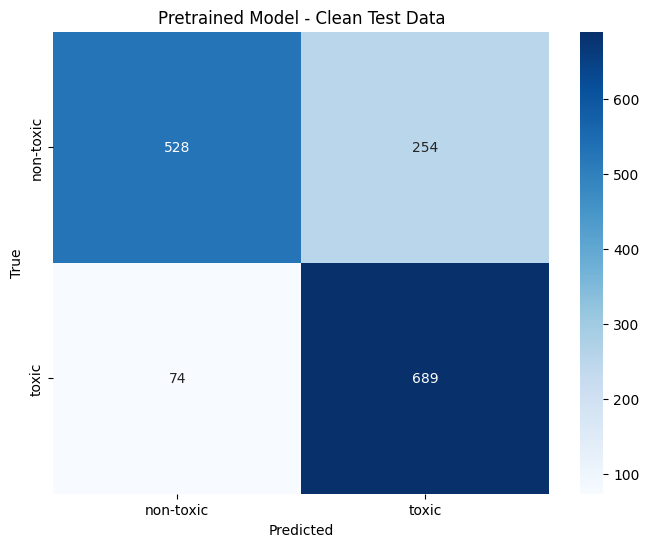

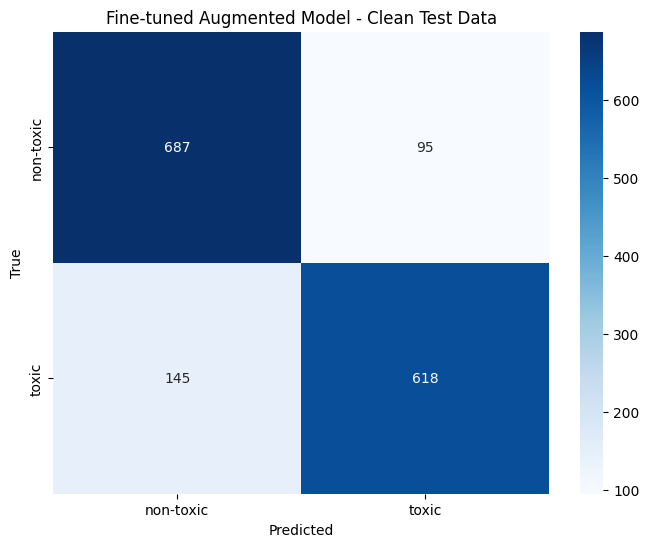

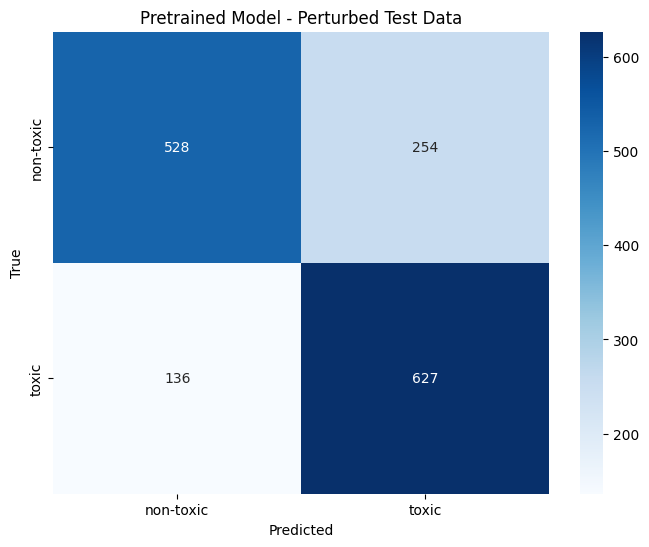

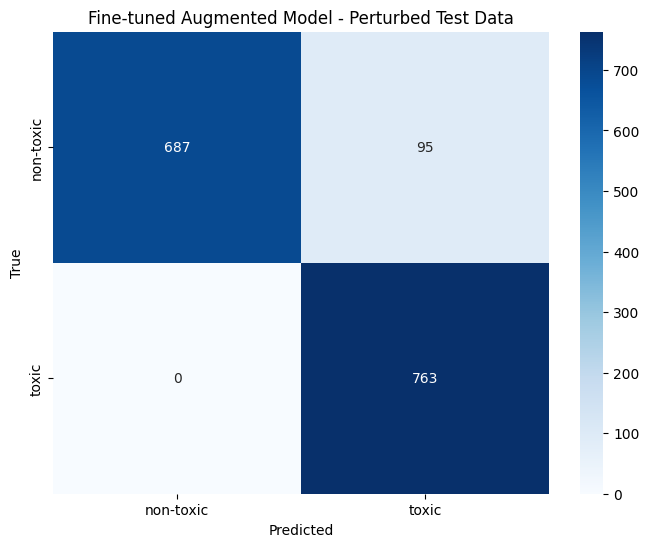

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["non-toxic", "toxic"], yticklabels=["non-toxic", "toxic"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
# Plot confusion matrices for clean test data
# plot_confusion_matrix(labels_final_clean_int, preds_finetuned_clean, title="Fine-tuned Model - Clean Test Data")
plot_confusion_matrix(labels_final_clean_int, preds_pretrained_clean, title="Pretrained Model - Clean Test Data")
# plot_confusion_matrix(labels_final_clean_int, preds_pretrained_new_clean, title="Pretrained New Model - Clean Test Data")
plot_confusion_matrix(labels_final_clean_int, preds_finetuned_aug_clean, title="Fine-tuned Augmented Model - Clean Test Data")  
# Plot confusion matrices for perturbed test data
# plot_confusion_matrix(labels_final_perturb_int, preds_finetuned_perturb, title="Fine-tuned Model - Perturbed Test Data")
plot_confusion_matrix(labels_final_perturb_int, preds_pretrained_perturb, title="Pretrained Model - Perturbed Test Data")
# plot_confusion_matrix(labels_final_perturb_int, preds_pretrained_new_perturb, title="Pretrained New Model - Perturbed Test Data")
plot_confusion_matrix(labels_final_perturb_int, preds_finetuned_clean_aug_perturb, title="Fine-tuned Augmented Model - Perturbed Test Data")